# Data Cleaning 

Analysing the dataset's information we can see that the shared data are the trip duration (although this figure is not always given explicitly but can be calculated by having the time of departure and arrival), the starting and ending station (name or ID), the user type and the bike ID.

These data are not present in all datasets: duration is not present in the newer version of CityBike NYC, in CoGo's trips data and in Divvy's data, start and end times are not present in the Austin MetroBike (it is only present the end time and the duration so we can infer that), start and end stations are not present in the Austin MetroBike and the bike id is not present in Divvy's dataset.
It therefore seems impossible to have data shared by all datasets but those reported to you may be the most important ones to work on.

Another information that is present in some of the dataset are the year of Birth, the gender and the station latitude and longitude. The first two data can be useful for a social analysis on the age and the gender of the user in different cities but this data are only presented in the older version of the CityBike NYC, in BluBike (through ... check) and in CoGo's dataset (randomly, in some months it is present and in others it is not, and it changes format. These data are present only through January 2020).

Starting year of each dataset:
- CityBike NYC, 2013
- BlueBike Boston, 2015
- Capital BikeShare Washington, 2010
- Bay Wheels San Francisco, 2017
- CoGo Columbus, 2018
- Austin MetroBike, 2014 (mixed)
- Divvy Chicago, (2014, incomplete) 2020
- IndeGo Philly, 2015 (incomplete)

Note: 2018-01 Columbus not present, 2018-02 has wrong data

These functions are currently usable with the dataset of NYC, Boston, Washington and San Francisco.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
from datetime import datetime

data_dir = 'D:\\unitn\\Bike-Inequality\\data'

In [78]:
def get_missing_data(df):
    # Get the number of missing data points per column
    missing_values_count = df.isnull().sum()

    # How many total missing values do we have?
    total_cells = np.prod(df.shape)
    total_missing = missing_values_count.sum()

    # Percent of data that is missing
    percent_missing = (total_missing/total_cells) * 100

    return percent_missing

## Get the duration information
The function get_duration_info() takes a DataFrame, analyzes the data internally and clusters them into five different classes: '< 500', '< 1000', '< 10000', '< 100000' and '> 100000'.

In [79]:
def get_time(df, number_to_analyse, full_path):
    '''
    get the duration of the trip for each file
    '''
    durations = list()
    if 'trip_duration_seconds' in df or 'trip_duration_minutes' in df:
        if 'trip_duration_seconds' in df:
            duration = df['trip_duration_seconds']
            durations = [time for time in duration]
        else:
            duration = df['trip_duration_minutes']
            durations = [time * 60 for time in duration]
    else:
        start = df['start_time']
        end = df['stop_time']
        format_dictionary = {
            'data\\NYC': {
                '202102': "%Y-%m-%d %H:%M:%S",
                'default': "%Y-%m-%d %H:%M:%S.%f"
            },
            'data\\Philly': {
                'default': "%Y-%m-%d %H:%M:%S"
            },
            'data\\Columbus': {
                'default': "%Y-%m-%d %H:%M:%S"
            },
            'data\\Chicago': {
                'default': "%Y-%m-%d %H:%M:%S"
            },
            'data\\Boston': {
                '202304': "%Y-%m-%d %H:%M:%S",
                'default': "%Y-%m-%d %H:%M:%S.%f"
            }
        }
        if 'NYC' in full_path:
            if full_path[14:20] >= '202102':
                date_format = "%Y-%m-%d %H:%M:%S"
            else:
                date_format = "%Y-%m-%d %H:%M:%S.%f"
            for index in range(len(end)):
                time = datetime.strptime(end[index], date_format) - datetime.strptime(start[index], date_format)
                durations.append(time.total_seconds())
        elif 'Philly' in full_path:
            for index in range(len(end)):
                month = datetime.strptime(end[index], '%Y-%m-%d %H:%M:%S').month
                if number_to_analyse == month:
                    time = datetime.strptime(end[index], "%Y-%m-%d %H:%M:%S") - datetime.strptime(start[index], "%Y-%m-%d %H:%M:%S")
                    durations.append(time.total_seconds())
        elif 'Columbus' in full_path:
            for index in range(len(end)):
                time = datetime.strptime(end[index], "%Y-%m-%d %H:%M:%S") - datetime.strptime(start[index], "%Y-%m-%d %H:%M:%S")
                durations.append(time.total_seconds())
        elif 'Chicago' in full_path:        
            for index in range(len(end)):
                time = datetime.strptime(end[index], "%Y-%m-%d %H:%M:%S") - datetime.strptime(start[index], "%Y-%m-%d %H:%M:%S")
                durations.append(time.total_seconds())
        elif 'Boston' in full_path:
            for index in range(len(end)):
                time = datetime.strptime(end[index], "%Y-%m-%d %H:%M:%S") - datetime.strptime(start[index], "%Y-%m-%d %H:%M:%S")
                durations.append(time.total_seconds())
        elif 'SanFrancisco' in full_path:
            for index in range(len(end)):
                time = datetime.strptime(end[index], "%Y-%m-%d %H:%M:%S") - datetime.strptime(start[index], "%Y-%m-%d %H:%M:%S")
                durations.append(time.total_seconds())
        elif 'Washington' in full_path:
            for index in range(len(end)):
                time = datetime.strptime(end[index], "%Y-%m-%d %H:%M:%S") - datetime.strptime(start[index], "%Y-%m-%d %H:%M:%S")
                durations.append(time.total_seconds())
        
    durations.sort()
    return durations

def get_duration_info(df, number, axs, fig, full_path):
    '''
    function to get the duration information for each file, cluster them and plot the frequency of each cluster
    '''
    durations = get_time(df, number, full_path)

    # Define a function to determine the cluster for each number
    def get_cluster(num):
        if type(num) == str:
            num = int(float(num.replace(',', '')))
        if num < 500:
            return "<500"
        elif num < 1000:
            return "<1000"
        elif num < 10000:
            return "<10000"
        elif num < 100000:
            return "<100000"
        else:
            return ">100000"

    # Group numbers into clusters
    clusters = [get_cluster(num) for num in durations]

    # Calculate frequency of each cluster
    frequency = Counter(clusters)

    # Extract cluster names and their frequencies
    total = sum(frequency.values())
    for key in frequency:
        frequency[key] /= total
    
    return frequency

def prepare_plot(axs, fig, frequency, number, data_dir):
    x = number // 3
    y = number % 3
    cluster_names = list(frequency.keys())
    cluster_frequencies = list(frequency.values())
    axs[x, y].bar(cluster_names, cluster_frequencies)
    for index in range(len(cluster_names)):
        axs[x, y].text(index, cluster_frequencies[index], str(round(cluster_frequencies[index], 5)), ha='center')

    # Add labels and title
    for ax in axs.flat:
        ax.set(xlabel='Trip duration', ylabel='Frequency')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    title = 'Frequency of Trip Duration for ' + data_dir
    fig.suptitle(title)

# Data Analysis
## Monthly duration frequency of ride 
Data is divided into multiple file so we need to integrate in a single file the data of a single month in order to evaluate them together.

In [80]:
def data_for_month(data_dir):

    data_files = os.listdir(data_dir)
    month = 0

    fig, ax = plt.subplots(4, 3)

    for file in data_files:
        # read data from each file into a DataFrame
        file_path = os.path.join(data_dir, file)
        
        df = pd.read_csv(file_path)
        
        if 'Philly' in data_dir or ('Chicago' in file_path and file_path[18:24] < '202004') or  ('Chicago' in file_path and '2020Q1' in file_path):
            month = (int(file[5:6]) - 1) * 3
            for _ in range(3):
                frequency = get_duration_info(df, month, ax, fig, file_path)
                prepare_plot(ax, fig, frequency, month, data_dir)
                month += 1
        else:
            month = int(file[4:6]) - 1
            frequency = get_duration_info(df, month, ax, fig, file_path)
            prepare_plot(ax, fig, frequency, month, data_dir)
    
    plt.show()

## Yearly duration frequency
The function data_for_year() take the data from each file and return the frequency for each ride duration interval.

In [81]:
def data_for_year(data_dir):
    '''
    function to plot the data for each year
    '''

    fig, ax = plt.subplots(2, 3)
    yearly_frequency = {
        '<500': 0,
        '<1000': 0,
        '<10000': 0,
        '<100000': 0,
        '>100000': 0
    }
    
    
    for year in os.listdir(data_dir):
        year_path = os.path.join(data_dir, year)
        for file in os.listdir(year_path):
            file_path = os.path.join(year_path, file)
            df = pd.read_csv(file_path, dtype='object')
            frequency = get_duration_info(df, year, ax, fig, file_path)
            for key in frequency:
                yearly_frequency[key] += frequency[key]
        year = int(year) - 2018
        total = sum(yearly_frequency.values())
        for key in yearly_frequency:
            yearly_frequency[key] /= total
        prepare_plot(ax, fig, yearly_frequency, year, year_path)
        frequency.clear()
    
    # Show plot
    plt.show()

## Gender analysis
The function data_integration_for_gender() take the data from each file and count how many people for each gender there are in it and add it to the dictionary genders_infos.
At the end plot the data with a pie chart.

In [82]:
def data_for_gender(data_dir):

    data_files = os.listdir(data_dir)
    genders_infos = {
        'unknown': 0,
        'men': 0,
        'women': 0,
    }

    for year in data_files:
        # read data from each file into a DataFrame
        year_path = os.path.join(data_dir, year)
        for file in os.listdir(year_path):
            
            file_path = os.path.join(year_path, file)
            
            df = pd.read_csv(file_path, dtype='object')
            count = df['gender'].value_counts()
            # plot the percentage of each data
            if 'unknown' in count:
                genders_infos['unknown'] += count.loc['unknown']
            if '1' in count:
                genders_infos['unknown'] += count.loc['0']
                genders_infos['men'] += count.loc['1']
                genders_infos['women'] += count.loc['2']
            if 'Male' in count:
                if 'Unknown' in count:
                    genders_infos['unknown'] += count.loc['Unknown']
                genders_infos['men'] += count.loc['Male']
                genders_infos['women'] += count.loc['Female']
    
    print(genders_infos)
    if genders_infos['men'] != 0 or genders_infos['women'] != 0:
        fig, ax = plt.subplots()
        plt.title(data_dir)
        plt.pie(genders_infos.values(), labels=genders_infos.keys(),  autopct='%1.1f%%')
        plt.show()
    else:
        print('Gender data not available in this city:', data_dir[5:])

## User Type analysis
The function data_integration_for_usertype() take the data from each file and count how many people for each subscription there are in it and add it to the dictionary usertypes_infos.
At the end plot the data with a pie chart.

In [83]:
def data_for_usertype(data_dir):
    
    data_files = os.listdir(data_dir)
    if 'Philly' in data_dir:
        usertypes_infos = {
            'Indego30': 0,
            'Indego365': 0,
            'Walk-up': 0,
            'Day Pass': 0,
            'IndegoFlex': 0,
        }
    elif 'Austin' in data_dir:
        usertypes_infos = {
            'Walk Up': 0,
            'Local365': 0,
            'Local30': 0,
            'Local365+Guest Pass': 0,
            'Republic Rider': 0,
        }
    else:
        usertypes_infos = {
            'unknown': 0,
            'customers': 0,
            'subscribers': 0,
        }

    for year in data_files:
        # read data from each file into a DataFrame
        year_path = os.path.join(data_dir, year)
        
        for file in os.listdir(year_path):
            file_path = os.path.join(year_path, file)
        
            df = pd.read_csv(file_path, dtype='object')
            count = df['usertype'].value_counts()
            if 'unknown' in count:
                usertypes_infos['unknown'] += count['unknown']
            if 'Customer' in count:
                usertypes_infos['customers'] += count['Customer']
                usertypes_infos['subscribers'] += count['Subscriber']
            if 'member' in count:
                usertypes_infos['customers'] += count['casual']
                usertypes_infos['subscribers'] += count['member']
            if 'Member' in count:
                usertypes_infos['customers'] += count['Casual']
                usertypes_infos['subscribers'] += count['Member']
            if 'Philly' in file_path:
                if 'Indego30' in count:
                    usertypes_infos['Indego30'] += count['Indego30']
                if 'Indego365' in count:
                    usertypes_infos['Indego365'] += count['Indego365']
                if 'Walk-up' in count:
                    usertypes_infos['Walk-up'] += count['Walk-up']
                if 'Day Pass' in count:
                    usertypes_infos['Day Pass'] += count['Day Pass']
                if 'IndegoFlex' in count:
                    usertypes_infos['IndegoFlex'] += count['IndegoFlex']
            if 'Austin' in file_path:
                if 'Walk Up' in count:
                    usertypes_infos['Walk Up'] += count['Walk Up']
                if 'Local365' in count:
                    usertypes_infos['Local365'] += count['Local365']
                if 'Local30' in count:
                    usertypes_infos['Local30'] += count['Local30']
                if 'Local365+Guest Pass' in count:
                    usertypes_infos['Local365+Guest Pass'] += count['Local365+Guest Pass']
                if 'Republic Rider' in count:
                    usertypes_infos['Republic Rider'] += count['Republic Rider (Annual)']
    
    fig, ax = plt.subplots()
    plt.title(data_dir)
    print(usertypes_infos)
    plt.pie(usertypes_infos.values(), labels=usertypes_infos.keys(),  autopct='%1.1f%%')
    plt.show()

## Main

City: Austin
Year: 2018
        Trip ID   usertype Bicycle ID bike_type               stop_time  \
0      16593120    Walk Up       2288   classic  01/15/2018 05:12:13 PM   
1      16576718    Walk Up        281   classic  01/10/2018 10:43:36 AM   
2      16588251    Walk Up        241   classic  01/14/2018 10:53:20 AM   
3      16598868    Walk Up        937   classic  01/17/2018 04:41:36 PM   
4      16612702   Explorer        141   classic  01/22/2018 11:09:19 AM   
...         ...        ...        ...       ...                     ...   
11160  16611197        NaN        116   classic  01/21/2018 03:39:24 PM   
11161  16638445  Weekender        334   classic  01/29/2018 04:43:24 PM   
11162  16586772        NaN        855   classic  01/13/2018 04:04:45 PM   
11163  16589431        NaN        801   classic  01/14/2018 02:32:24 PM   
11164  16574134        NaN        466   classic  01/09/2018 02:34:24 PM   

      Checkout Date Checkout Time  Checkout Kiosk ID           Checkout Kio

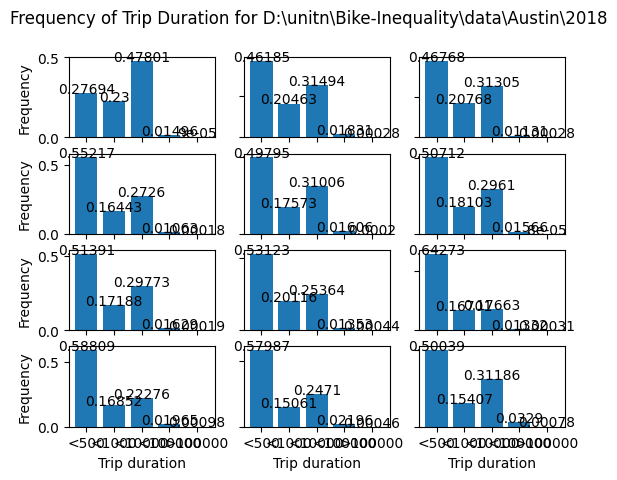

Year: 2019
       Trip ID                 usertype Bicycle ID bike_type  \
0     19205955           3-Day Explorer     15040E  electric   
1     19226980              Single Trip        198   classic   
2     19143507                  Local30        298   classic   
3     19168107                 Explorer       050G   classic   
4     19181486              Single Trip       353G   classic   
...        ...                      ...        ...       ...   
9090  19212588  U.T. Student Membership       1704   classic   
9091  19210676  U.T. Student Membership        391   classic   
9092  19198310                  Local30       2828   classic   
9093  19202223              Single Trip        302   classic   
9094  19199524  U.T. Student Membership       281G   classic   

                   stop_time Checkout Date Checkout Time  Checkout Kiosk ID  \
0     01/21/2019 11:38:47 AM    01/21/2019      11:38:47               2552   
1     01/28/2019 03:03:33 PM    01/28/2019      15:03:33      

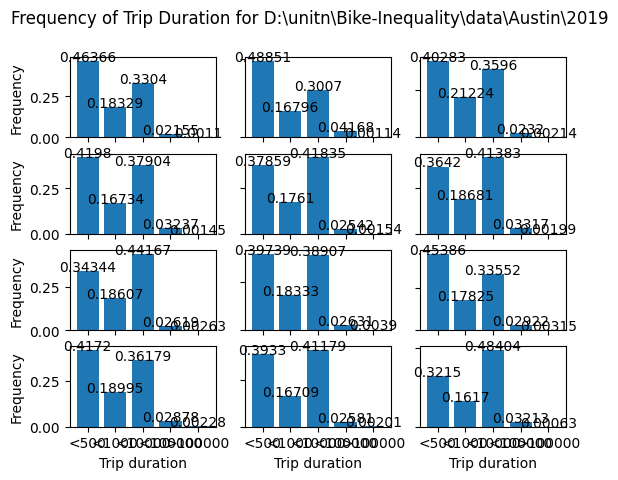

Year: 2020
       Trip ID                       usertype Bicycle ID bike_type  \
0     21513032                            NaN       1967   classic   
1     21529539                       Local365       3201   classic   
2     21509939                       Local365        200   classic   
3     21470935                       Local365        161   classic   
4     21512231                       Explorer        135   classic   
...        ...                            ...        ...       ...   
4524  21490001                       Local365       1857   classic   
4525  21490021                       Explorer       1486   classic   
4526  21490107  Single Trip (Pay-as-you-ride)        873   classic   
4527  21487894           24 Hour Walk Up Pass       227G   classic   
4528  21516367                        Local30        911   classic   

                   stop_time Checkout Date Checkout Time  Checkout Kiosk ID  \
0     01/26/2020 03:19:58 PM    01/26/2020      15:19:58             

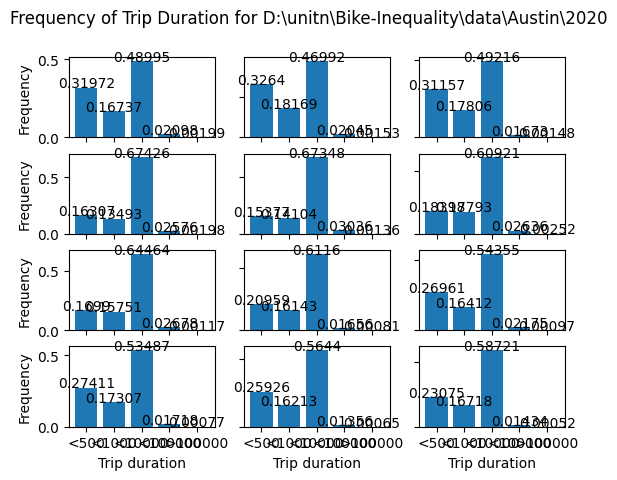

Year: 2021


KeyboardInterrupt: 

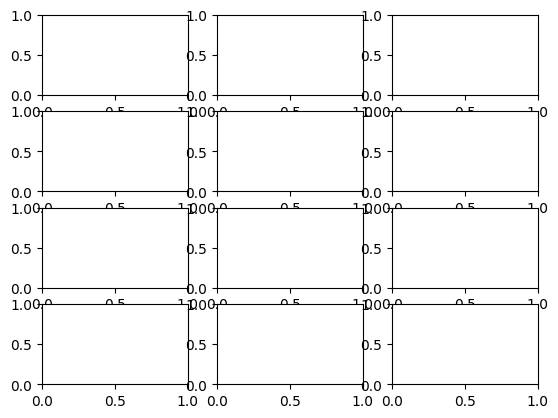

In [84]:
for file in os.listdir(data_dir):
    print('City:', file)
    data_dir_city = os.path.join(data_dir, file)
    
    # plot date for each month
    for year in os.listdir(data_dir_city):
        print('Year:', year)
        data_dir_city_year = os.path.join(data_dir_city, year)
        data_for_month(data_dir_city_year)
    
    data_for_year(data_dir_city)
    data_for_gender(data_dir_city)
    data_for_usertype(data_dir_city)